<a href="https://colab.research.google.com/github/thienluc2017/fraud-detection/blob/main/LGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#kết nối với drive
from google.colab import drive      
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#load thư viện cần thiết và các tệp trong dữ liệu
import pandas as pd   
import numpy as np    
identity = pd.read_csv('/content/drive/MyDrive/data/train_identity.csv')   

In [ ]:
transaction = pd.read_csv('/content/drive/MyDrive/data/train_transaction.csv')  

In [ ]:
#Nối 2 tệp giúp cho việc xử lý dữ liệu tốt hơn
train = transaction.merge(identity, how = 'left')  

In [ ]:
#hàm giảm bộ nhớ dữ liệu
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

#**1.Xử lý dữ liệu**

In [ ]:
null_cols = [col for col in train.columns if train[col].isnull().sum() / train.shape[0] > 0.9]

In [ ]:
train.drop(null_cols,axis=1,inplace=True)

In [ ]:
#điền các dữ liệu bị missing
for i in train.columns:
    if train[i].dtypes=='int64' or train[i].dtypes=='float64':   
        train[i].fillna(train[i].mean(),inplace=True)

In [ ]:
#điền các dữ liệu bị missing
for i in train.columns:
    if train[i].dtypes=='object':     
        train[i].fillna(train[i].mode()[0],inplace=True)

In [ ]:
train.shape

(590540, 422)

In [ ]:
train['transaction_day_of_the_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)

In [ ]:
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24

In [ ]:
train['device_name'] = train['DeviceInfo'].str.split('/', expand=True)[0]  

In [ ]:
train['device_version'] = train['DeviceInfo'].str.split('/', expand=True)[1]  

In [ ]:
train['OS_id_30'] = train['id_30'].str.split(' ', expand=True)[0]   

In [ ]:
train['version_id_30'] = train['id_30'].str.split(' ', expand=True)[1]   

In [ ]:
train['browser_id_31'] = train['id_31'].str.split(' ', expand=True)[0]   

In [ ]:
train['version_id_31'] = train['id_31'].str.split(' ', expand=True)[1]  

In [ ]:
train['id_34'] = train['id_34'].str.split(':', expand=True)[1]

In [ ]:
train.loc[train['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'

In [ ]:
train.loc[train['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'

In [ ]:
train.loc[train['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'

In [ ]:
train.loc[train['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
train.loc[train['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
train.loc[train['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
train.loc[train['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
train.loc[train['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
train.loc[train['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
train.loc[train['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
train.loc[train['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
train.loc[train['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
train.loc[train['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
train.loc[train['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
train.loc[train['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
train.loc[train['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
train.loc[train['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'
train.loc[train.device_name.isin(train.device_name.value_counts()[train.device_name.value_counts() < 200].index), 'device_name'] = "Others"

In [ ]:
train.loc[train['device_name']=='Others'].count()

TransactionID     5530
isFraud           5530
TransactionDT     5530
TransactionAmt    5530
ProductCD         5530
                  ... 
device_version    4140
OS_id_30          5530
version_id_30     5411
browser_id_31     5530
version_id_31     5209
Length: 430, dtype: int64

In [ ]:
train_vcol =[]
for i in range(1,340):
  train_vcol.append('V'+str(i))
vcol=train[train_vcol] 
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
pca.fit(vcol)
pca.explained_variance_ratio_.sum()

0.9947927236500623

In [ ]:
vcol1=pca.transform(vcol)
train.drop(vcol,axis=1,inplace=True)
vcol1 = pd.DataFrame(vcol1)
train=pd.concat([train,vcol1],axis=1)
train = reduce_mem_usage(train)

Memory usage of dataframe is 428.02 MB
Memory usage after optimization is: 99.26 MB
Decreased by 76.8%


In [ ]:
train.shape

(590540, 94)

In [ ]:
cat_cols = ['id_12','id_15', 'id_16','id_28', 'id_29','id_30', 'id_31', 'id_33', 'id_34', 'id_35', 
            'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo', 'ProductCD', 'card4', 'card6', 'M4','P_emaildomain',
            'R_emaildomain', 'addr1', 'addr2', 'M1', 'M2', 'M3', 'M5', 'M6', 'M7', 'M8', 'M9','device_name','device_version','OS_id_30','version_id_30']

In [ ]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in cat_cols:
  if i in train.columns:
    train[i] = le.fit_transform(train[i].astype(str).values)

In [ ]:
y= train['isFraud']
print(y.shape)

(590540,)


In [ ]:
x = train.drop(['isFraud','TransactionID','TransactionDT'],axis=1)
print(x.shape)

(590540, 91)


In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x,y,stratify = y,test_size = 0.3, random_state=1)

#**2.LGBM**

In [ ]:
#chuẩn bị model ,dữ liệu và huấn luyện
%timeit
import lightgbm as lgb
d_train = lgb.Dataset(x_train,label=y_train)
params={}
params['task'] = 'train'                       
params['boosting_type'] = "gbdt"
params['application'] = 'classification'
params['objective'] = 'binary'
params['metric'] = 'auc'
params['random_state'] = 1
model = lgb.train(params, d_train, 5000)     

In [ ]:
predict = model.predict(x_test)     

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

In [ ]:
#in ra các số liệu
predict = model.predict(x_test)
ROC=[]
ACC = []
for j in np.arange(0.1,0.99,step=.05):
  predict2=np.array(list(predict))
  for i in range(len(y_test)):
    if predict[i]>=j:
      predict2[i]=1               
    else:
      predict2[i]=0
  ROC.append(roc_auc_score(predict2,y_test))
  conf = confusion_matrix(predict2,y_test)
  ACC.append((conf[0,0]+conf[1,1]) / len(y_test))
print(ROC)
print(ACC)

[0.9279545940569716, 0.9458712632727909, 0.9570053048788802, 0.9647806134938127, 0.9690144270941539, 0.9724979947526149, 0.9762618978499138, 0.9781443028760859, 0.980561651868748, 0.9815246681300049, 0.9821640370475009, 0.9831994285989711, 0.9838975344443514, 0.9849540026122411, 0.9860935149958556, 0.9862572516184089, 0.9864523099597138, 0.9868366229017502]
[0.987977105699868, 0.9886883191655096, 0.9889423239746673, 0.9890326367957011, 0.9889253903207234, 0.9886657409602511, 0.9885415608313295, 0.9883327124326887, 0.9881577313419356, 0.9878472810196317, 0.9875029633894402, 0.987181223964507, 0.9868199726803716, 0.9864135649857193, 0.9858773326108308, 0.985137896388616, 0.9842065454217044, 0.9826373601562411]


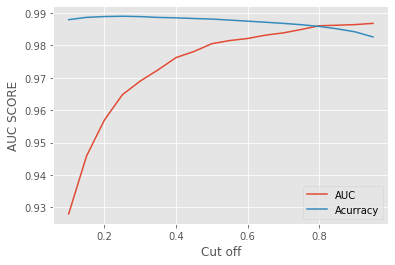

In [ ]:
#biểu đồ line graph
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
plt.ylabel('AUC SCORE')          
plt.xlabel('Cut off')
plt.plot(np.arange(0.1,0.99,step=.05),ROC,label='AUC')
plt.plot(np.arange(0.1,0.99,step=.05),ACC,label='Acurracy')
plt.legend()
plt.show()

In [ ]:
predict3 = np.array(list(predict))
for i in range(len(y_test)):
  if predict[i]>=0.2:            
    predict3[i]=1
  else:
    predict3[i]=0

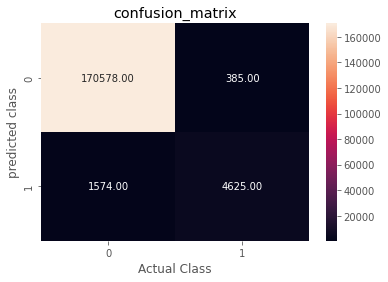

In [ ]:
#biểu đồ confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,predict3)
sns.heatmap(cm,annot=True,fmt='.2f')
plt.title('confusion_matrix')         
plt.xlabel('Actual Class')
plt.ylabel('predicted class')
plt.show()

In [ ]:
#in ra kết quả AUC(ROC)
roc_auc_score(y_test,predict3)    

0.8719180647350986